In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import string
from PIL import Image, ImageFont, ImageDraw, ImageOps
import json
from collections import deque
import copy
from decimal import *

getcontext().prec = 100000000

Populating the interactive namespace from numpy and matplotlib


## Input

In [2]:
# Enter text with lowercase Latin letters and single spaces between words
text = "noisy milk"
noise = 0.2

## Process

In [3]:
if noise > Decimal("0.5"):
    noise = Decimal("0.5")
if noise < Decimal("0."):
    noise = Decimal("0.")
text = "a" + text + "a"

## Paths

In [4]:
path_to_frequencies = "./frequencies.json"

## Useful functions

In [5]:
def epsilon_close(a, b, epsilon):
    return (a < b + epsilon) and (a > b - epsilon)

def xor(a, b):
    return bool(a) != bool(b)

## Initialize alphabet

In [6]:
def get_img_from_char(c):
    font = ImageFont.truetype('RobotoMono-Bold.ttf', 14)
    img = Image.new("RGB", (9, 15), None)
    img = ImageOps.grayscale(img) 
    draw = ImageDraw.Draw(img)
    draw.text((0, -1), c, font=font, fill="white")
    return img

alphabet = list(string.ascii_lowercase)
# alphabet += list(string.ascii_uppercase)
alphabet.append(" ")
alphabet_without_space = list(string.ascii_lowercase)

alphabet_images = dict.fromkeys(alphabet)

for c in alphabet:
    alphabet_images[c] = np.asarray(get_img_from_char(c)).copy()
    h, w = alphabet_images[c].shape
    for i in range(h):
        for j in range(w):
            if alphabet_images[c][i][j] < 75:
                alphabet_images[c][i][j] = 0
            else:
                alphabet_images[c][i][j] = 1

cheight, cwidth = alphabet_images[' '].shape

# for c in alphabet:
#     figure(figsize=(10, 10))
#     imshow(alphabet_images[c], cmap='gray')
#     show()

## Frequencies

In [7]:
probabilities = {}

if path_to_frequencies:
    json_file = open(path_to_frequencies, 'r')
    frequencies = json.load(json_file)
    for first_letter in alphabet:
        first_letter_amount = 0.
        for second_letter in alphabet:
            key = first_letter + second_letter
            if key in frequencies:
                first_letter_amount += frequencies[key]
        for second_letter in alphabet:
            key = first_letter + second_letter
            if key in frequencies:
                probabilities[key] = Decimal(str(frequencies[key] / first_letter_amount))
            else:
                probabilities[key] = Decimal("0.")
else:
    for first_letter in alphabet:
        for second_letter in alphabet:
            key = first_letter + second_letter
            probabilities[key] = Decimal(str(1. / len(alphabet)))

## Generate image from text

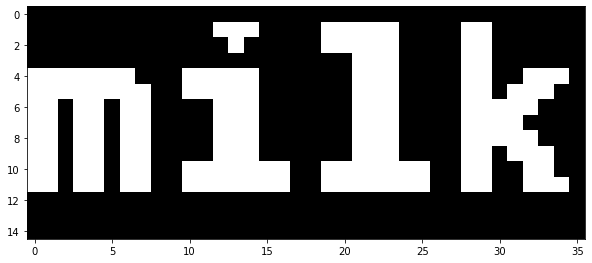

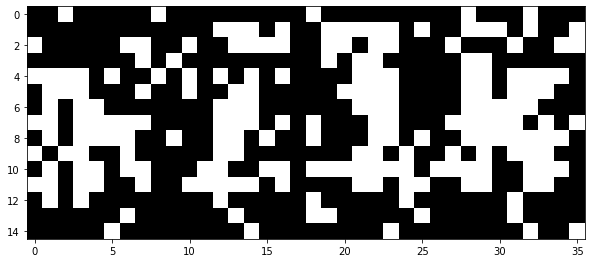

In [8]:
img = alphabet_images[text[0]]
for c in range(1, len(text)):
    img = np.concatenate((img, alphabet_images[text[c]]), axis=1)
    
h, w = img.shape
N = len(text)
        
figure(figsize=(10, 10))
imshow(img[0:h, cwidth:w-cwidth], cmap='gray')
show()
img_ = Image.fromarray((img[0:h, cwidth:w-cwidth] * 255).astype(numpy.uint8))
img_.save(text[1:N-1] + " " + str(noise) + " original.png")

for i in range(h):
    for j in range(w):
        img[i][j] = xor(img[i][j], (np.random.random() < noise))
figure(figsize=(10, 10))
imshow(img[0:h, cwidth:w-cwidth], cmap='gray')
show()
img_ = Image.fromarray((img[0:h, cwidth:w-cwidth] * 255).astype(numpy.uint8))
img_.save(text[1:N-1] + " " + str(noise) + " noised.png")

## Solving

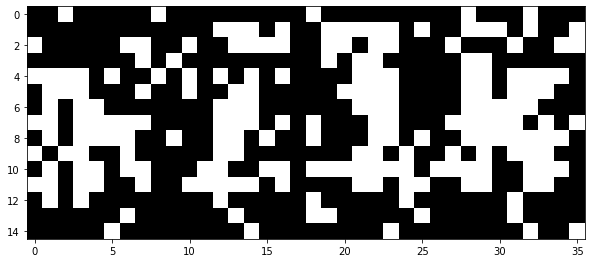

In [9]:
def probability_of_letter(letter, number):
    probability = 1.
    for i in range(cheight):
        for j in range(cwidth):
            temp1 = noise ** xor(img[i][j + number * cwidth], alphabet_images[letter][i][j])
            temp2 = (1 - noise) ** xor(True, xor(img[i][j + number * cwidth], alphabet_images[letter][i][j]))
            probability *= temp1 * temp2
    return Decimal(str(probability))

prob_of_letter = np.empty([len(alphabet), N], dtype=np.dtype(Decimal))
for i, c in enumerate(alphabet):
    for j in range(N):
        prob_of_letter[i][j] = probability_of_letter(c, j)

def F(j):
    Fs_j = np.empty(j - 1, np.dtype(Decimal))
    
    f = np.empty((j, len(alphabet_without_space)), np.dtype(Decimal))
    for row in range(j):
        for el in range(len(alphabet_without_space)):
            f[row][el] = Decimal("0.")
                
    for t, k in enumerate(alphabet_without_space):
        f[j - 1][t] = probabilities[k + " "]
        if j != N - 1:
            f[j - 1][t] *= prob_of_letter[len(alphabet) - 1][j]
    
    for i in range(j - 2, -1, -1):
    
        if (j - i < 1):
            Fs_j[i] = Decimal("0.")
        else:

            for ij in range(j - 2 - i, 0, -1):
                for t, k in enumerate(alphabet_without_space):
                    for t_, k_ in enumerate(alphabet_without_space):
                        f[ij + i][t] += probabilities[k + k_] * prob_of_letter[t_][ij + 1 + i] * f[ij + i + 1][t_]

            ij = 1
            if i == 0:
                ij = 0
                for t, k in enumerate(alphabet_without_space):
                    for t_, k_ in enumerate(alphabet_without_space):
                        f[ij + i][t] += probabilities[k + k_] * prob_of_letter[t_][ij + 1 + i] * f[ij + i + 1][t_]
            result = Decimal("0.")
            for t_, k_ in enumerate(alphabet_without_space):
                result += probabilities[" " + k_] * prob_of_letter[t_][ij + i] * f[ij + i][t_]

            Fs_j[i] = result
            
    return Fs_j

Fs = np.empty([N - 1, N], np.dtype(Decimal))
for j in range(N):
    for i in range(N - 1):
        Fs[i][j] = Decimal("0.")

for j in range(2, N):
    Fs_j = F(j)
    for i in range(j - 1):
        Fs[i][j] = Fs_j[i]

picked_i = np.zeros(N, np.int32)
G = np.empty(N, np.dtype(Decimal))
for i in range(N):
    G[i] = Decimal("0.")
G[0] = Decimal("1.")
picked_i[0] = -1
for j in range(1, N):
    best_i = -1
    best_G = -1
    for i in range(j):
        cur = G[i] * Fs[i][j]
        if cur > best_G:
            best_G = cur
            best_i = i
    G[j] = G[best_i] * Fs[best_i][j]
    picked_i[j] = int(best_i)

picked = [picked_i[N - 1]]
cur_v = picked[0]
while cur_v > 0:
    cur_v = picked_i[cur_v]
    if cur_v > 0:
        picked.append(cur_v)

for p in picked:
    img[0:cheight, p*cwidth:(p+1)*cwidth] = 1
    
figure(figsize=(10, 10))
imshow(img[0:h, cwidth:w-cwidth], cmap='gray')
show()
img_ = Image.fromarray((img[0:h, cwidth:w-cwidth] * 255).astype(numpy.uint8))
img_.save(text[1:N-1] + " " + str(noise) + " spaces.png")